In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
import mne
data_dir = 'data_meg'
subj = "R2490"
dataqual = 'prepro' #or loc/exp
exp = 'loc' #or exp
dtype = "raw"
label_dir = 'data_log'
save_dir = 'data_meg'
bad_channels_dict = {
    "R2490": ['MEG 014', 'MEG 004', 'MEG 079', 'MEG 072', 'MEG 070', 'MEG 080', 'MEG 074', 'MEG 067', 'MEG 082', 'MEG 105', 'MEG 115', 'MEG 141', 'MEG 153'],
    "R2488": ['MEG 015', 'MEG 014', 'MEG 068', 'MEG 079', 'MEG 146', 'MEG 147', 'MEG 007', 'MEG 141'],
    "R2487": ['MEG 015', 'MEG 014', 'MEG 068', 'MEG 079', 'MEG 147', 'MEG 146', 'MEG 004'],
    "R2280": ['MEG 024', 'MEG 039', 'MEG 079', 'MEG 077', 'MEG 141', 'MEG 073', 'MEG 075', 'MEG 076', 'MEG 064', 'MEG 063', 'MEG 060', 'MEG 059', 'MEG 058']
}
bad_channels = bad_channels_dict.get(subj, [])


In [2]:
# raw = mne.io.read_raw_fif('data_meg/R2490/prepro/R2490_exp.fif', preload='temp_raw.fif')
raw = mne.io.read_raw_fif(f'{data_dir}/{subj}/{dataqual}/{subj}_{exp}.fif', preload=True)
raw.info['bads'].extend(bad_channels)
sfreq = raw.info['sfreq']
raw.filter(1, 40, method='iir')
downsample = 10
raw.resample(sfreq / downsample)
raw.drop_channels(bad_channels)

Opening raw data file data_meg/R2490/prepro/R2490_loc.fif...


/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_91896/591528618.py:2: RuntimeWarning: This filename (data_meg/R2490/prepro/R2490_loc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(f'{data_dir}/{subj}/{dataqual}/{subj}_{exp}.fif', preload=True)


    Range : 0 ... 669999 =      0.000 ...   669.999 secs
Ready.
Reading 0 ... 669999  =      0.000 ...   669.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB

425 events found on stim channel STI 014
Event IDs: [160 164 165 166]
362 events found on stim channel STI 014
Event IDs: [160 164 165 166]


/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_91896/591528618.py:7: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  raw.resample(sfreq / downsample)


<Raw | R2490_loc.fif, 180 x 67000 (670.0 s), ~93.6 MB, data loaded>

In [3]:
events = mne.find_events(raw, stim_channel='STI 014', output='onset', shortest_event=1)
event_id = {
    'start': 160,
    'move': 161,
    'reveal_red': 162,
    'reveal_white': 163,
    'done': 164,
    'choice': 165,
    'timeout': 166
}

# Define trials to remove
trials_to_remove = []

362 events found on stim channel STI 014
Event IDs: [160 164 165 166]


In [4]:
start_events = events[events[:, 2] == event_id['start']]
done_events = events[events[:, 2] == event_id['done']] 
timeout_events = events[events[:, 2] == event_id['timeout']]
choice_events = events[events[:, 2] == event_id['choice']]
sfreq = raw.info['sfreq']

In [5]:
if subj == "R2488" :
    done_events = done_events[1:]

In [6]:

# Initialize a list to store filtered done events
filtered_done_events = [done_events[0]]  # Start with the first event

# Check for at least 3 seconds between each done event
for i in range(1, len(done_events)):
    time_diff = (done_events[i, 0] - done_events[i-1, 0]) / sfreq
    if time_diff < 2:
        print(f"Warning: Less than 3 seconds between done events at indices {i-1} and {i}")
    
    else:
        filtered_done_events.append(done_events[i])
done_events = filtered_done_events
done_events = done_events[-120:]
# Use filtered_done_events for further processing
print(f"Filtered done events count: {len(filtered_done_events)}")



Filtered done events count: 120


In [7]:
choice_events = events[events[:, 2] == event_id['choice']]
# start_events = np.array([[done_event[0] - int(3.4 * sfreq), 0, event_id['start']] for done_event in done_events])
start_events = events[events[:, 2] == event_id['start']]
# start_events = start_events[-120:]
sfreq = raw.info['sfreq']  # Sampling frequency


# Initialize a list to store trial information
trial_info = []
start_idx = 0

# Iterate through each reconstructed start event to create trial information
for start_event, done_event in zip(start_events, done_events):
    start_sample = start_event[0]
    done_sample = done_event[0]
    # done_sample = start_sample + int(3.4 * sfreq)
    # Calculate tmin and tmax for the epoch
    tmin = -0.2  # 0.2 s before 'start'
    tmax = (done_sample - start_sample) / sfreq  # Duration from 'start' to 'done'
    # Find choice events within the trial
    choice_event = choice_events[(choice_events[:, 0] > start_sample) & 
                                 (choice_events[:, 0] < done_sample + int(0.5*sfreq))]
    choice_time = choice_event[-1, 0] if len(choice_event) > 0 else None
    
    # Store trial information
    trial_info.append({
        'event_sample': done_sample,
        'trial_index': start_idx,
        'duration': tmax,
        'tmin': tmin,
        'tmax': tmax,
        'done': len(done_events) > 0,
        'done_times': done_sample / sfreq,
        'start_times': start_sample / sfreq,
        'choice_event': len(choice_event) > 0,
        'choice_time': choice_time / sfreq if len(choice_event) > 0 else None
    })
    start_idx += 1

In [15]:
# Use the trial information to create epochs
picks = mne.pick_types(raw.info, meg=True, exclude='bads')
data_list = []
for info in trial_info:
    start_sample = info['start_times'] * sfreq
    done_sample = info['done_times'] * sfreq
    tmin = -0.5 # 0.2 s before 'start'
    tmax = 1  # Duration from 'start' to 'done'
    print(start_sample, done_sample)
    event = [int(done_sample), 0, event_id['done']]
    epochs = mne.Epochs(
        raw, [event], event_id={'done': event_id['done']},
        tmin=tmin, tmax=tmax, preload=True, picks=picks,
        reject_by_annotation=False, reject=None, verbose=True
    )
    data_list.append(epochs.get_data())

4057.0 4398.0
Not setting metadata
1 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 151 original time points ...
0 bad epochs dropped
4558.0 4900.0
Not setting metadata
1 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 151 original time points ...
0 bad epochs dropped
5053.0 5395.0
Not setting metadata
1 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 151 original time points ...
0 bad epochs dropped
5550.0 5891.0
Not setting metadata
1 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from p

In [9]:
# new_events = np.array([[info['event_sample'], 0, event_id['done']] for info in trial_info])
# choice_events = np.array([[info['event_sample'], 0, event_id['choice']] for info in trial_info])

# # Initialize lists to store individual epochs data and trial information
# data_list = []

# for idx, event in enumerate(new_events):
#     choice_time = info['choice_time']  # Retrieve choice_time for the current trial
#     if choice_time is not None:
#         start_sample = int(choice_time * sfreq)  # Convert choice_time to sample index
#         tmin = -0.5  # 0.5 s before 'choice'
#         tmax = 0.5  # 0.5 s after 'choice'
#     else:
#         start_sample = int(info['done_times'] * sfreq)  # Use done time if choice_time is not available
#         tmin = -3.5  # 1 s before 'done'
#         tmax = 0.1 # At 'done'
    
#     event_id_code = event_id['choice'] if choice_time is not None else event_id['done']
#     event = [start_sample, 0, event_id_code]
#     picks = mne.pick_types(raw.info, meg=True, exclude='bads')

#     epochs = mne.Epochs(
#         raw, [event], event_id={f'event_{event_id_code}': event_id_code},
#         tmin=tmin, tmax=tmax, preload=True, picks=picks,
#         reject_by_annotation=False, reject=None, verbose=True
#     )
#     data_list.append(epochs.get_data())

In [10]:
print(len(data_list))

120


In [11]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import LeaveOneOut
from mne.decoding import SlidingEstimator, cross_val_multiscore, Vectorizer, GeneralizingEstimator
from scipy.ndimage import gaussian_filter1d
import joblib  # For saving the model

In [16]:
# Assuming X is your feature matrix with shape (n_epochs, n_channels, n_times)
X = np.array([md.data for md in data_list])  # Ensure this is 3D
X = X.squeeze(axis=1)  # This might reduce dimensions, ensure it's still 3D

# Load the CSV file
locolizer = pd.read_csv(f'{label_dir}/{subj}/loc_data.csv')

# Extract valid trial indices
valid_trial_indices = {info['trial_index'] for info in trial_info}

# Extract labels and group information
rule_label = locolizer.loc[locolizer['trial_index'].isin(valid_trial_indices), 'rule'].values
group_start = locolizer.loc[locolizer['trial_index'].isin(valid_trial_indices), 'num_start'].values
y = np.array(group_start)
# Identify unique group_start labels
unique_groups = np.unique(group_start)
n_classes = len(unique_groups)


def flatten_data(X):
    n_samples, n_channels, n_timepoints = X.shape
    print(n_samples, n_channels, n_timepoints)
    return X.reshape(n_samples, n_channels * n_timepoints)

def smooth_scores(scores, sigma=2):
    return gaussian_filter1d(scores, sigma=sigma)

def plot_time_decoding(scores_mean,title, subj):
    n_time_points = scores_mean.shape[0]

    plt.plot(np.arange(n_time_points), scores_mean)
    plt.ylim(0, 0.6)
    plt.axhline(1/n_classes, color='k', linestyle='--', label='chance')
    plt.axvline(50, color='k', linestyle='--')
    plt.xlabel('Time Points')
    plt.ylabel('Accuracy')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Define the two groups based on a new threshold value
threshold = 15
group_data = {'greater_than_15': [], 'smaller_than_15': []}
group_labels = {'greater_than_15': [], 'smaller_than_15': []}

# Populate group_data and group_labels based on the new threshold
for idx, info in enumerate(trial_info):
    trial_index = info['trial_index']
    if trial_index in valid_trial_indices:
        group_value = group_start[idx]  # Assuming group_start is the feature to be compared
        if group_value > threshold:
            group = 'greater_than_15'
        else:
            group = 'smaller_than_15'
        
        # Ensure the group is correctly assigned
        if group in group_data:
            group_data[group].append(X[idx])  # Ensure X[idx] is 3D
            group_labels[group].append(rule_label[idx])
        else:
            print(f"Unexpected group value: {group_value}")



# # Train and evaluate the model for each group
# for group in ['greater_than_15', 'smaller_than_15']:
#     X_group = np.array(group_data[group])
#     y_group = np.array(group_labels[group])
    
#     # Debugging: Check the shape of X_group
#     print(f"Group: {group}, X_group shape: {X_group.shape}")
    
#     cv = LeaveOneOut()
    
#     # Train the decoder
#     clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
#     time_decoding = SlidingEstimator(clf, n_jobs=5, scoring='accuracy')

#     scores = cross_val_multiscore(time_decoding, X_group, y_group, cv=cv, n_jobs=5)
#     scores_mean = np.mean(scores, axis=0)
#     plot_time_decoding(scores_mean, f'Time Decoding {group}', subj)

X shape: (120, 144, 151), y_label shape: (120,)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
  0%|          | Fitting SlidingEstimator : 0/151 [00:00<?,       ?it/s]
  0%|          | Fitting SlidingEstimator : 0/151 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/151 [00:00<?,       ?it/s]


  0%|          | Fitting SlidingEstimator : 0/151 [00:00<?,       ?it/s]



  1%|          | Fitting SlidingEstimator : 1/151 [00:03<09:34,    3.83s/it][A

  1%|          | Fitting SlidingEstimator : 1/151 [00:03<09:30,    3.80s/it]



  1%|          | Fitting SlidingEstimator : 1/151 [00:03<09:12,    3.68s/it]
  1%|          | Fitting SlidingEstimator : 1/151 [00:03<09:56,    3.98s/it]
  1%|▏         | Fitting SlidingEstimator : 2/151 [00:04<04:54,    1.98s/it]



  1%|▏         | Fitting SlidingEstimator : 2/151 [00:03<04:42,    1.89s/it]

  1%|▏         | Fitting SlidingEstimator : 2/151 [00:04<05:07,    2.06s/it]

  2%|▏         | Fitting SlidingEstimator : 3/151 [00:04<03:15,    1.32s/it]


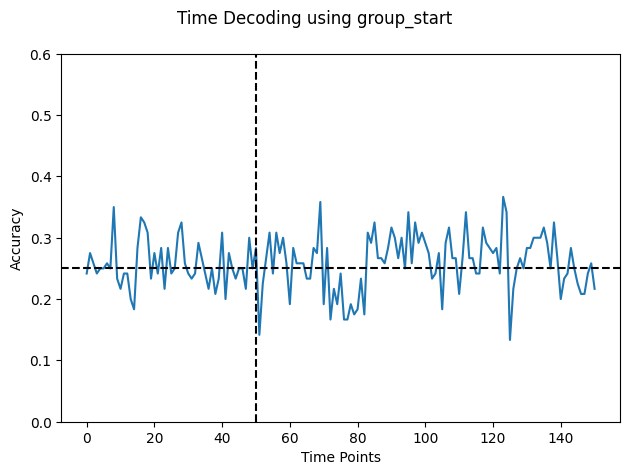

In [17]:
from sklearn.model_selection import StratifiedKFold
# Extract group_start as y_label
y_label = locolizer.loc[locolizer['trial_index'].isin(valid_trial_indices), 'num_start'].values

# Ensure X is 3D and y_label is aligned with X
X = np.array([md.data for md in data_list])  # Ensure this is 3D
X = X.squeeze(axis=1)  # This might reduce dimensions, ensure it's still 3D

# Debugging: Check the shape of X and y_label
print(f"X shape: {X.shape}, y_label shape: {y_label.shape}")

# Train and evaluate the model using group_start as y_label
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

clf = make_pipeline(StandardScaler(), LogisticRegressionCV(max_iter=1000))
time_decoding = SlidingEstimator(clf, n_jobs=5, scoring='accuracy')

scores = cross_val_multiscore(time_decoding, X, y_label, cv=cv, n_jobs=5)
scores_mean = np.mean(scores, axis=0)
plot_time_decoding(scores_mean, 'Time Decoding using group_start', subj)


In [14]:
save_dir = f'output/{subj}'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
np.save(f'{save_dir}/{subj}_group_start.npy', scores_mean)